# Exploring ERA5 Weather Data with Zarr


---

This demo showcases how to efficiently access and analyze large climate datasets using the Zarr format with ERA5 data stored on Google Cloud.


## 1. Introduction to ERA5

ERA5 is the fifth generation of atmospheric reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). 

### What is Reanalysis?
Reanalysis is a scientific method that creates a consistent, best-estimate reconstruction of Earth's past weather and climate by combining:

Historical Observations:

1. Surface stations
1. Weather balloons
1. Satellites
1. Ships and buoys
1. Aircraft reports

Numerical Weather Models:

1. Modern physics equations
1. Data assimilation techniques
1. Supercomputing power

### Key Characteristics:

- **"Best guess"** of past weather: Fills gaps where direct observations are missing
- **Temporally consistent**: Uses one modern system for entire period (unaffected by changing observation technologies)
- **Spatially complete**: Provides global coverage even over oceans/polar regions

### Key Features:
- **Global coverage**: Data for the entire Earth at high resolution
- **Temporal range**: 1950 to present (with hourly data from 1979)
- **Spatial resolution**: 0.25° latitude/longitude (~31 km grid)
- **Variables**: 240+ weather parameters (temperature, precipitation, wind, etc.)
- **Data assimilation**: Combines models with observations for consistency

### Relevant Resources:
1. [Official ECMWF ERA5 Documentation](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)
2. [ERA5 Data Access Guide](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation)
3. [Google Cloud Public Dataset Info](https://cloud.google.com/storage/docs/public-datasets/era5)
4. [ARCO-ERA5 Project](https://github.com/google-research/arco-era5)
5. [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)

## 2. Setting Up the Distributed Computing Environment

First, we'll set up a distributed computing cluster using Dask and SLURM to handle the large dataset efficiently.


In [1]:
import xarray as xr
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

In [2]:
from dask.distributed import LocalCluster, Client

# Create a local cluster
cluster = LocalCluster(
    n_workers=4,              # Use 4 cores
    memory_limit='16GB',        # Total memory limit
    dashboard_address=':8787'  # Web dashboard port
)

# Connect client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45661/status,
Dashboard: http://127.0.0.1:45661/status,Workers: 4
Total threads: 12,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35197,Workers: 0
Dashboard: http://127.0.0.1:45661/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34589,Total threads: 3
Dashboard: http://127.0.0.1:34587/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:44905,


In [3]:
# cluster = SLURMCluster(
#     name="test1",
#     cores=4,
#     memory="8GB",
#     processes=True,
#     scheduler_options={"dashboard_address": ":0"}
# )
# client = Client(cluster)  # Connect to distributed cluster and override default
# client

## 3. Accessing ERA5 Data in Zarr format

Now we'll open the [ERA5 dataset](https://cloud.google.com/storage/docs/public-datasets/era5) stored in Zarr format on Google Cloud Storage.

Let's check first what is inside the cloud bucket.

In [4]:
import fsspec

fs = fsspec.filesystem('gcs', token='anon')
store_path = 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
files = fs.ls(store_path)

for f in files[:10]:
    print(f)

gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_v_component_of_wind
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_neutral_wind
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_neutral_wind
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_wind_gust_since_previous_post_processing


Now, we can look inside the `.zmetadata` file

In [5]:
import json

fs = fsspec.filesystem('gcs', token='anon')
path = 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata'

with fs.open(path, 'r') as f:
    zmetadata = json.load(f)

In [6]:
# zmetadata

In [7]:
zmetadata["metadata"][".zattrs"]

{'valid_time_start': '1940-01-01',
 'last_updated': '2025-06-17 01:47:41.835277+00:00',
 'valid_time_stop': '2025-02-28',
 'valid_time_stop_era5t': '2025-06-11'}

In [8]:
zmetadata["metadata"]["2m_temperature/.zarray"]

{'chunks': [1, 721, 1440],
 'compressor': {'blocksize': 0,
  'clevel': 5,
  'cname': 'lz4',
  'id': 'blosc',
  'shuffle': 1},
 'dtype': '<f4',
 'fill_value': 'NaN',
 'filters': None,
 'order': 'C',
 'shape': [1323648, 721, 1440],
 'zarr_format': 2}

Now open the ERA 5 using `xarray`

In [9]:
%%time
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    # chunks=None,
    chunks={},
    consolidated=True,
    storage_options=dict(token='anon'),
)

CPU times: user 1min 20s, sys: 4.79 s, total: 1min 25s
Wall time: 1min 24s


In [10]:
ds

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-06-17 01:47:41.835277+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-06-11

In [11]:
total_bytes = ds.nbytes
print(f"Dataset size: {total_bytes / 1024**5:.2f} PiB")

Dataset size: 3.27 PiB


## 4. Data Slicing & Querying

### 4.1 Data selection
Understanding ERA5's arrays (Variables)

In [12]:
ds.data_vars

Data variables:
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10

Let's get the 2 meter above the ground temperature `2m_temperature` array - variable

In [13]:
t2m =  ds['2m_temperature']  # or ds.t2m
t2m

<xarray.DataArray '2m_temperature' (time: 1323648, latitude: 721,
                                    longitude: 1440)> Size: 5TB
dask.array<open_dataset-2m_temperature, shape=(1323648, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

### 4.2. Data slicing

#### 4.2.1. Time slicing
Understanding ERA5's time

In [14]:
print(f"Time range: {ds.time.min().values} to {ds.time.max().values}")

Time range: 1900-01-01T00:00:00.000000000 to 2050-12-31T23:00:00.000000000


In [15]:
# Time dimension analysis
time_res_ns = int(ds.time.diff('time')[0].values)  # nanoseconds
time_res_hours = time_res_ns / (1e9 * 3600)        # convert to hours

# Calculate total time span
total_ns = int(ds.time[-1].values - ds.time[0].values)
total_days = total_ns / (1e9 * 3600 * 24)
total_years = total_days / 365.25

# Count of time steps
n_steps = len(ds.time)

print(f"{total_days:,.0f} days")
print(f"{total_years:,.0f} years")
print(f"\nNumber of time steps: {n_steps:,}")
print(f"Expected steps: {int(total_days * 24):,} (hourly data)")

55,152 days
151 years

Number of time steps: 1,323,648
Expected steps: 1,323,647 (hourly data)


* **Historical Reanalysis (1900-1978)**
     - Lower quality than main ERA5
     - Uses fewer observations
     - Primarily useful for long-term climate studies
     - Note: The official ERA5 starts in 1950, but this extended version includes preliminary data back to 1900

In [16]:
%%time
temp_hist = t2m.sel(time=slice('1900', '1978'))
temp_hist

CPU times: user 1.98 s, sys: 250 ms, total: 2.23 s
Wall time: 2.22 s


<xarray.DataArray '2m_temperature' (time: 692496, latitude: 721, longitude: 1440)> Size: 3TB
dask.array<getitem, shape=(692496, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6MB 1900-01-01 ... 1978-12-31T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [17]:
print(f"Historical Temperature size: {temp_hist.nbytes / 1024**4:.2f} TB")

Historical Temperature size: 2.62 TB


* **Main ERA5 Reanalysis (1979-Present)**
     - Highest quality period
     - Incorporates satellite era data
     - Hourly temporal resolution
     - 0.25° spatial resolution

*  **ERA5 Forecasts (Future Dates)**
  
        - Model projections beyond present day
        - Multiple ensemble members possible
        - Useful for testing model systems
        - Not a true forecast - generated with fixed sea surface temperatures

#### 4.2.2. Lat - Lon Slicing
we can selec data by lon lat cordinates. lets first check how data looks like

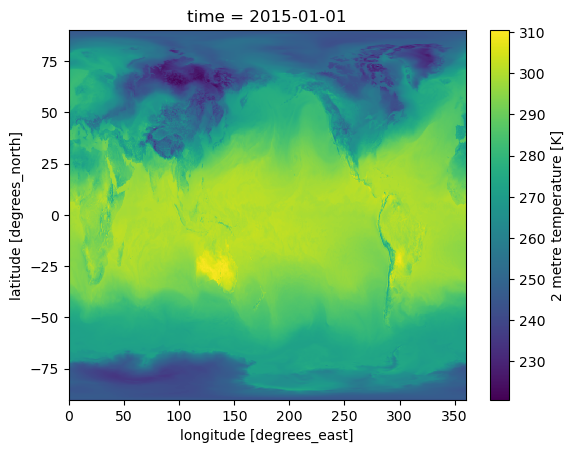

In [18]:
t2m.sel(time="2015-01-01 00:00").plot()

In this array data is in 0 to 360 in longitude and 80 to -80 in latitude. We can slice data for Colombia as follows

In [19]:
t2m_col = t2m.sel(longitude=slice(275, 300), latitude=slice(14, -3))

In [20]:
t2m_col

<xarray.DataArray '2m_temperature' (time: 1323648, latitude: 69, longitude: 101)> Size: 37GB
dask.array<getitem, shape=(1323648, 69, 101), dtype=float32, chunksize=(1, 69, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 276B 14.0 13.75 13.5 13.25 ... -2.5 -2.75 -3.0
  * longitude  (longitude) float32 404B 275.0 275.2 275.5 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

## 5. Streaming Visualization of Temperature Data

**Concept: Lazy Loading + Progressive Rendering**

This section demonstrates how to visualize massive ERA5 temperature datasets without loading everything into memory fetch only the required data chunks on-demand (via Dask + Zarr)

In [21]:
# Enable matplotlib interactive mode
import matplotlib.pyplot as plt

### 5.1. Basic Streaming Plot


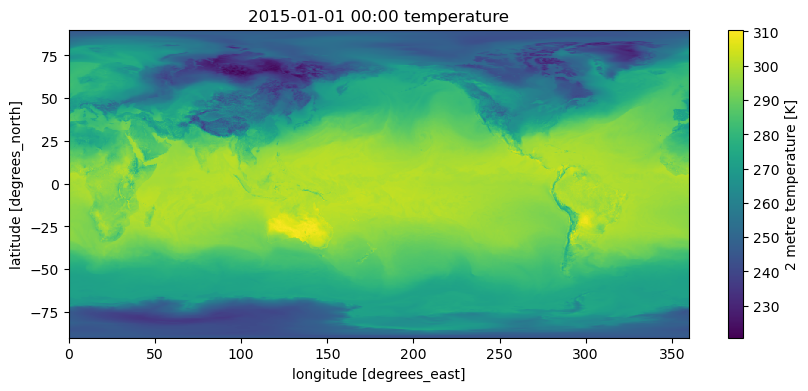

In [22]:
fig, ax = plt.subplots(figsize=(10,4))
t2m.sel(time="2015-01-01 00:00").plot()
ax.set_title("2015-01-01 00:00 temperature" )
plt.show()

### 5.2. Mean Temperature Trends for Colombia in January, 2010

Lets try to compute how the mean temperature for Colombia will looks like in 2010


In [23]:
col_temp_2010 = t2m_col.sel(time="2010-01") - 273.15
col_temp_2010

<xarray.DataArray '2m_temperature' (time: 744, latitude: 69, longitude: 101)> Size: 21MB
dask.array<sub, shape=(744, 69, 101), dtype=float32, chunksize=(1, 69, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 276B 14.0 13.75 13.5 13.25 ... -2.5 -2.75 -3.0
  * longitude  (longitude) float32 404B 275.0 275.2 275.5 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:00:00

In [24]:
mean_temp_2010 = col_temp_2010.mean("time")

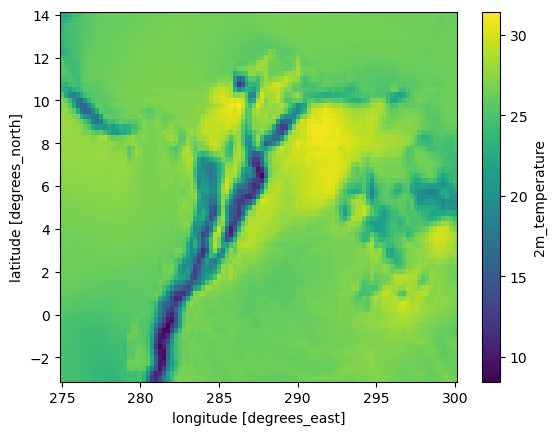

In [25]:
mean_temp_2010.plot()

## 6. Release the resources reserved on the High-Performance Computing System

In [26]:
cluster.close()

In [27]:
client.close()